In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.svm import LinearSVR,NuSVR,SVR
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from random import uniform,randint
from sklearn.metrics import make_scorer
from scipy.stats import truncnorm

In [2]:
linear_models = ['LinearRegression', 'Ridge', 'SGDRegressor', 'ElasticNet,Lars',
        'Lasso', 'LassoLars','OrthogonalMatchingPursuit','ARDRegression','BayesianRidge','HuberRegressor',
        'RANSACRegressor', 'TheilSenRegressor', 'PoissonRegressor','TweedieRegressor','GammaRegressor',
        'PassiveAggressiveRegressor']
models = []
for model in linear_models:
    try:
        exec(f"from sklearn.linear_model import {model}")
    except ImportError:
        print(f"Error importing {model}")

In [3]:
df = pd.read_pickle('finaldata.pkl')

In [4]:
df.head()

,globalId,primaryCategory.categoryName,paymentMethod,autoPay,sellerInfo.feedbackScore,sellerInfo.positiveFeedbackPercent,sellerInfo.feedbackRatingStar,sellerInfo.topRatedSeller,shippingInfo.shippingServiceCost.value,shippingInfo.shippingType,...,fault in desc,below in desc,new in desc,spares in desc,Day Started,Day Ended,Time Started,Time Ended,Start Price,Country
0,0,0,0,False,2,1,0,False,0.00,0,...,0,0,0,0,0,0,0,0,296.373739,0
1,0,0,0,False,3,1,1,False,4.99,1,...,1,0,0,0,1,0,0,1,68.887521,0
2,0,0,0,False,1,1,2,False,9.50,1,...,0,0,0,0,0,1,1,0,90.358858,1
3,0,0,0,False,2,1,0,False,7.50,1,...,0,0,1,0,1,2,1,0,0.000000,0
4,0,0,0,False,3,2,1,False,0.00,0,...,0,0,1,0,2,1,1,0,0.986582,0


In [5]:
for col in df.columns:
    if(df[col].dtype == 'bool'):
        df[col] = pd.factorize(df[col])[0] 

In [6]:
df_copy = df.copy()

In [7]:
df = df.reset_index(drop=True)

In [8]:
def create_training_and_test_data(df):
    Y_targets = np.array(df['Price'].values)
    X = np.array(df.drop(columns='Price').values)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,Y_targets,test_size=0.2,random_state=42,
                                                   shuffle=True)
    return X_train,X_test,y_train,y_test

In [9]:
X_train, X_test, y_train, y_test = create_training_and_test_data(df)

In [10]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
print(X_train.shape)
print(X_test.shape)

(14394, 82)
(3599, 82)


In [12]:
models = [LinearRegression(),Ridge(),SGDRegressor(),ElasticNet(),Lars(),Lasso(),
          LassoLars(),OrthogonalMatchingPursuit(),ARDRegression(),BayesianRidge(),
          HuberRegressor(),PoissonRegressor(),TweedieRegressor(),GammaRegressor(),
          PassiveAggressiveRegressor(),RANSACRegressor(),LinearSVR(),NuSVR(),
          SVR(),DecisionTreeRegressor(),ExtraTreeRegressor(),TheilSenRegressor(),
         RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor()]

In [13]:
def run_models(models,X_train,y_train,X_test,y_test):
    y_test_squared = np.square(y_test)
    y_train_squared = np.square(y_train)
    x_train_squared = np.square(X_train)
    x_test_squared = np.square(X_test)
    
    total_time_start = time.time()
    model_evaluation = pd.DataFrame(columns=['Model','Train MAPE','Train RMSE','Train CV Mean','Train CV STD',
                                            'Test MAPE','Test RMSE','Time Taken'])
    for index,model in enumerate(models):
        print(f'Now doing : {model} : This is model : {index + 1} out of {len(models)} ')
        df_values = []
        start = time.time()
        current_model = model.fit(X_train,y_train)
        model_train_predictions = current_model.predict(X_train)
        model_train_predictions_squared = np.square(model_train_predictions)
        train_mse = mean_squared_error(y_train_squared,model_train_predictions_squared)
        train_rmse = np.sqrt(train_mse)
        model_train_cv_score = cross_val_score(current_model, X_train, y_train,
                        scoring='neg_mean_squared_error',cv=10)
        
        model_train_scores_mean = model_train_cv_score.mean()
        train_scores_rmse = np.sqrt(-model_train_scores_mean)
        model_train_scores_std = model_train_cv_score.std()
        model_train_mape = mean_absolute_percentage_error(y_train_squared, model_train_predictions_squared)
        
        model_test_predictions = current_model.predict(X_test)
        model_test_predictions_squared = np.square(model_test_predictions)
        model_test_mse = mean_squared_error(y_test_squared, model_test_predictions_squared)
        test_rmse = np.sqrt(model_test_mse)
        model_test_mape = mean_absolute_percentage_error(y_test_squared, model_test_predictions_squared)
        end = time.time()
        time_taken = end - start
        df_values.extend([model,model_train_mape,train_rmse,train_scores_rmse,
                          model_train_scores_std,model_test_mape,test_rmse,time_taken])
        series_to_append = pd.Series(df_values,index=model_evaluation.columns)
        model_evaluation = model_evaluation.append(series_to_append,ignore_index=True)
    total_time_end = time.time()
    print(f'Time taken : {total_time_end - total_time_start}')
    return model_evaluation

In [14]:
df_models = run_models(models,X_train,y_train,X_test,y_test)

Now doing : LinearRegression() : This is model : 1 out of 25 
Now doing : Ridge() : This is model : 2 out of 25 
Now doing : SGDRegressor() : This is model : 3 out of 25 
Now doing : ElasticNet() : This is model : 4 out of 25 
Now doing : Lars() : This is model : 5 out of 25 


C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.313e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=6.540e-04, with an active set of 29 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.875e-04, with an act

C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.409e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=7.348e-04, with an active set of 27 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=3.668e-04, with an act

C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.351e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=6.613e-04, with an active set of 29 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=4.158e-04, with an act

Now doing : Lasso() : This is model : 6 out of 25 
Now doing : LassoLars() : This is model : 7 out of 25 
Now doing : OrthogonalMatchingPursuit() : This is model : 8 out of 25 
Now doing : ARDRegression() : This is model : 9 out of 25 
Now doing : BayesianRidge() : This is model : 10 out of 25 
Now doing : HuberRegressor() : This is model : 11 out of 25 
Now doing : PoissonRegressor() : This is model : 12 out of 25 
Now doing : TweedieRegressor() : This is model : 13 out of 25 
Now doing : GammaRegressor() : This is model : 14 out of 25 
Now doing : PassiveAggressiveRegressor() : This is model : 15 out of 25 
Now doing : RANSACRegressor() : This is model : 16 out of 25 
Now doing : LinearSVR() : This is model : 17 out of 25 


C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear f

Now doing : NuSVR() : This is model : 18 out of 25 
Now doing : SVR() : This is model : 19 out of 25 
Now doing : DecisionTreeRegressor() : This is model : 20 out of 25 
Now doing : ExtraTreeRegressor() : This is model : 21 out of 25 
Now doing : TheilSenRegressor(max_subpopulation=10000) : This is model : 22 out of 25 
Now doing : RandomForestRegressor() : This is model : 23 out of 25 
Now doing : AdaBoostRegressor() : This is model : 24 out of 25 
Now doing : GradientBoostingRegressor() : This is model : 25 out of 25 
Time taken : 1148.3054769039154


In [15]:
pd.set_option('display.float_format', '{:.2f}'.format)
df_models

,Model,Train MAPE,Train RMSE,Train CV Mean,Train CV STD,Test MAPE,Test RMSE,Time Taken
0,LinearRegression(),25.61,32.64,1.49,0.14,1552236677610843430243532800.00,13148722540706265264736436224.00,1.02
1,Ridge(),25.59,32.65,1.49,0.14,25.86,30.43,0.31
2,SGDRegressor(),25.63,33.44,1.51,0.15,25.65,30.69,1.19
3,ElasticNet(),41.46,45.44,2.10,0.18,43.95,44.97,0.40
4,Lars(),25.78,32.62,1.49,0.13,26.09,30.44,0.60
5,Lasso(),46.31,50.42,2.32,0.22,49.03,49.88,0.37
6,LassoLars(),50.96,53.97,2.50,0.24,54.35,53.59,0.29
7,OrthogonalMatchingPursuit(),30.14,36.05,1.67,0.17,30.95,34.74,0.30
8,ARDRegression(),25.62,32.69,1.49,0.14,25.90,30.44,3.34
9,BayesianRidge(),25.62,32.63,1.49,0.13,25.89,30.42,0.74


In [16]:
df_models[['Model','Test MAPE','Test RMSE']].sort_values(by='Test RMSE')

,Model,Test MAPE,Test RMSE
22,"(DecisionTreeRegressor(max_features='auto', ra...",19.07,25.31
24,([DecisionTreeRegressor(criterion='friedman_ms...,21.90,26.75
18,SVR(),24.15,28.15
17,NuSVR(),24.30,28.27
10,HuberRegressor(),25.94,30.32
16,LinearSVR(),26.28,30.35
9,BayesianRidge(),25.89,30.42
1,Ridge(),25.86,30.43
4,Lars(),26.09,30.44
8,ARDRegression(),25.90,30.44


In [17]:
def plot_first_5_predictions(models,X_train,y_train,X_test,y_test):
    plt.figure(figsize=(10,9))
    plt_colours = ['gd','b^','ys','r*','+']
    X_test_values = X_test[0:5]
    y_test_values = y_test[0:5]
    y_labels = [0,1,2,3,4]
    for colour,model in enumerate(models):
        current_model = model.fit(X_train,y_train)
        predictions = current_model.predict(X_test_values)
        plt.plot(predictions,plt_colours[colour],label=str(model))
    
    plt.plot(y_test_values,'or',label='Actual')
    plt.xlabel('Test Sample')
    plt.ylabel('Prediction')
    plt.legend(loc='best')
    plt.show()

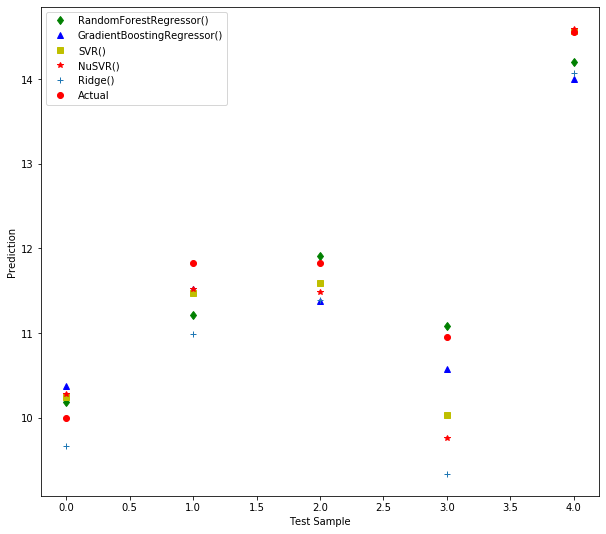

In [18]:
top_5_models = [RandomForestRegressor(),GradientBoostingRegressor(),SVR(),
                NuSVR(),Ridge()]
plot_first_5_predictions(top_5_models,X_train,y_train,X_test,y_test)

Data analysis after 1st linear Regression. There was 1 result in the X_test prediciton that was causing the error to sky rocket. This was because the category 'listingInfo.buyItNowAvailable' had 17992 values for false and then 1 value for True and it was majorly messing up the model. So I decided to remove this column and see how it affected the models.

In [19]:
df_1_altered = df_copy.copy()

In [20]:
df_1_altered = df_1_altered.drop(columns='listingInfo.buyItNowAvailable')
##Removing the acutal value where'listingInfo.buyItNowAvailable'' actually equals 1

In [21]:
X_train,X_test,y_train,y_test = create_training_and_test_data(df_1_altered)

In [22]:
print(X_train.shape)
print(X_test.shape)

(14394, 81)
(3599, 81)


In [23]:
df_1_altered_results = run_models(models,X_train,y_train,X_test,y_test)

Now doing : LinearRegression() : This is model : 1 out of 25 
Now doing : Ridge() : This is model : 2 out of 25 
Now doing : SGDRegressor() : This is model : 3 out of 25 
Now doing : ElasticNet() : This is model : 4 out of 25 
Now doing : Lars() : This is model : 5 out of 25 


C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.313e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=6.540e-04, with an active set of 29 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=3.190e-04, with an act

C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.409e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=7.348e-04, with an active set of 27 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 52 iterations, i.e. alpha=2.317e-04, with an act

C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=6.613e-04, with an active set of 29 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 42 iterations, i.e. alpha=3.252e-04, with an active set of 42 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_least_angle.py:578: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 67 iterations, i.e. alpha=1.133e-04, with an act

Now doing : Lasso() : This is model : 6 out of 25 
Now doing : LassoLars() : This is model : 7 out of 25 
Now doing : OrthogonalMatchingPursuit() : This is model : 8 out of 25 
Now doing : ARDRegression() : This is model : 9 out of 25 
Now doing : BayesianRidge() : This is model : 10 out of 25 
Now doing : HuberRegressor() : This is model : 11 out of 25 
Now doing : PoissonRegressor() : This is model : 12 out of 25 
Now doing : TweedieRegressor() : This is model : 13 out of 25 
Now doing : GammaRegressor() : This is model : 14 out of 25 
Now doing : PassiveAggressiveRegressor() : This is model : 15 out of 25 
Now doing : RANSACRegressor() : This is model : 16 out of 25 
Now doing : LinearSVR() : This is model : 17 out of 25 


C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear f

Now doing : NuSVR() : This is model : 18 out of 25 
Now doing : SVR() : This is model : 19 out of 25 
Now doing : DecisionTreeRegressor() : This is model : 20 out of 25 
Now doing : ExtraTreeRegressor() : This is model : 21 out of 25 
Now doing : TheilSenRegressor(max_subpopulation=10000) : This is model : 22 out of 25 
Now doing : RandomForestRegressor() : This is model : 23 out of 25 
Now doing : AdaBoostRegressor() : This is model : 24 out of 25 
Now doing : GradientBoostingRegressor() : This is model : 25 out of 25 
Time taken : 1147.195858001709


In [24]:
pd.set_option('display.float_format', '{:.2f}'.format)
df_1_altered_results

,Model,Train MAPE,Train RMSE,Train CV Mean,Train CV STD,Test MAPE,Test RMSE,Time Taken
0,LinearRegression(),25.59,32.65,1.49,0.14,25.86,30.43,0.52
1,Ridge(),25.59,32.65,1.49,0.14,25.86,30.43,0.22
2,SGDRegressor(),25.73,33.08,1.50,0.14,25.99,30.87,1.01
3,ElasticNet(),41.46,45.44,2.10,0.18,43.95,44.97,0.39
4,Lars(),25.73,32.63,1.49,0.14,26.04,30.43,0.52
5,Lasso(),46.31,50.42,2.32,0.22,49.03,49.88,0.33
6,LassoLars(),50.96,53.97,2.50,0.24,54.35,53.59,0.28
7,OrthogonalMatchingPursuit(),30.14,36.05,1.67,0.17,30.95,34.74,0.32
8,ARDRegression(),25.62,32.69,1.49,0.14,25.90,30.44,2.94
9,BayesianRidge(),25.62,32.63,1.49,0.13,25.89,30.42,0.82


In [25]:
df_1_altered_results[['Model','Test MAPE','Test RMSE']].sort_values(by='Test RMSE')

,Model,Test MAPE,Test RMSE
22,"(DecisionTreeRegressor(max_features='auto', ra...",19.14,25.40
24,([DecisionTreeRegressor(criterion='friedman_ms...,21.89,26.75
18,SVR(),24.09,28.12
17,NuSVR(),24.25,28.24
10,HuberRegressor(),26.02,30.33
9,BayesianRidge(),25.89,30.42
16,LinearSVR(),26.31,30.42
0,LinearRegression(),25.86,30.43
1,Ridge(),25.86,30.43
4,Lars(),26.04,30.43


It looks like RandomForestRegressor() did the best then GradientBoostingRegressor(), SVR(), NuSVR() and then a lot of the models have the same RMSE. I'll try and random grid search some of the best models to try and improve the scores.